<a href="https://colab.research.google.com/github/ricardo-kowalski/teste/blob/master/atividade_kmeans_knn_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Desafio "Catch Me If You Can"#

Desafio:
* Aplicar o métodos de agrupamento k-means ao conjunto de teste;
* Treinar o conjunto de teste utilizando o algoritmo knn e as predições fornecidas pelo k-means;
* Remover as labels do conjunto de treino;
* Aplicar o método de predição knn ao conjunto de treino;
* Comparar as labels da predição com as originais;

##LEITURA DOS DATASETS##

In [0]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/drive', force_remount=True)
%cd /drive/My\ Drive/CURSO I2A2/DESAFIO_KMEANS_KNN
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /drive
/drive/My Drive/CURSO I2A2/DESAFIO_KMEANS_KNN
site_dic.pkl		train_sessions.csv	 versao1.ipynb	versao4.ipynb
test_sessions.csv	train_sessions_text.txt  versao2.ipynb	versao5.ipynb
test_sessions_text.txt	Untitled0.ipynb		 versao3.ipynb


In [0]:
# Import libraries and set desired options
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression


In [0]:
times = ['time%s' % i for i in range(1, 11)]
sites = ['site%s' % i for i in range(1, 11)]

train_df = pd.read_csv('train_sessions.csv', parse_dates = times, index_col='session_id')
test_df = pd.read_csv('test_sessions.csv', parse_dates = times, index_col='session_id')

In [0]:
# Answer
print(test_df.shape, train_df.shape)

(82797, 20) (253561, 21)


In [0]:
# Convert time1, ..., time10 columns to datetime type
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


Número de targets:
0    251264
1      2297
Name: target, dtype: int64


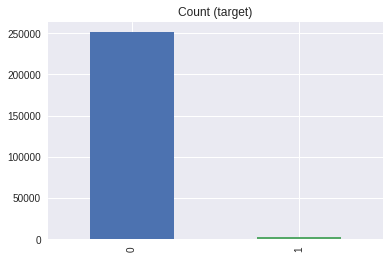

In [0]:
'''Conta a quantidade de linhas de acordo com as labels 0 e 1 '''
#train.groupby(['target']).size()

print('Número de targets:')
print(train_df.iloc[:,-1].value_counts())
train_df.iloc[:,-1].value_counts().plot(kind='bar', title='Count (target)');



---



##PRÉ PROCESSAMENTO ##

Para o pré-processamento foi utilizado o método seguinte:
https://www.kaggle.com/kashnitsky/correct-time-aware-cross-validation-scheme

In [0]:
# Labels
y_train = train_df['target'].values

In [0]:
# small
sites = ['site%s' % i for i in range(1, 11)]

train_df[sites].fillna(0).to_csv('train_sessions_text.txt', 
                                 sep=' ', index=None, header=None)

test_df[sites].fillna(0).to_csv('test_sessions_text.txt', 
                                sep=' ', index=None, header=None)

In [0]:
!head -3 train_sessions_text.txt

56 55.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
56 55.0 56.0 55.0 0.0 0.0 0.0 0.0 0.0 0.0
946 946.0 951.0 946.0 946.0 945.0 948.0 784.0 949.0 946.0


Vetorização dos dados categóricos (sites)

In [0]:
%%time
cv = CountVectorizer(ngram_range=(1, 3), max_features=50000)
with open('train_sessions_text.txt') as inp_train_file:
    X_train = cv.fit_transform(inp_train_file)
with open('test_sessions_text.txt') as inp_test_file:
    X_test = cv.transform(inp_test_file)
print(X_train.shape, X_test.shape)

(253561, 50000) (82797, 50000)
CPU times: user 15 s, sys: 424 ms, total: 15.4 s
Wall time: 15.5 s


In [0]:
#remove a coluna 'target'

train_df = train_df.drop('target', axis=1)



---



##DIVIDINDO O DATASET EM TIME SERIES##

In [0]:
from sklearn.model_selection import TimeSeriesSplit

time_split = TimeSeriesSplit(n_splits=10)

In [0]:
[(el[0].shape, el[1].shape) for el in time_split.split(X_test)]

[((7527,), (7527,)),
 ((15054,), (7527,)),
 ((22581,), (7527,)),
 ((30108,), (7527,)),
 ((37635,), (7527,)),
 ((45162,), (7527,)),
 ((52689,), (7527,)),
 ((60216,), (7527,)),
 ((67743,), (7527,)),
 ((75270,), (7527,))]



---



##K-MEANS##

In [0]:
%%time
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state = 42).fit(X_test)


CPU times: user 1min 30s, sys: 9.81 s, total: 1min 39s
Wall time: 1min 27s


In [0]:
labels_kmeans_test = kmeans.labels_

print(labels_kmeans_test )

[0 1 0 ... 0 0 0]


In [0]:
'''Conta a quantidade de 0 e 1 '''

print('Número de targets:')

print('nº zeros: ', np.sum(labels_kmeans_test == 0))
print('nº uns: ', np.sum(labels_kmeans_test == 1))

Número de targets:
nº zeros:  80204
nº uns:  2593




---



##KNN - ESCOLHENDO O MELHOR K ##

Teste para vários k

https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/


###SEGUNDO A ACURÁCIA###

In [0]:
%%time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# subsetting just the odd ones
neighbors = [1,3,5,7,9,11,13,15]     #TESTE COM 8 VALORES APENAS


# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn2 = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn2, X_test, labels_kmeans_test, cv = time_split, scoring='accuracy')
    cv_scores.append(scores.mean())

CPU times: user 9min 22s, sys: 5.96 s, total: 9min 28s
Wall time: 9min 28s




---



[0.9986714494486515, 0.9988043045037862, 0.9989105885478942, 0.998990301580975, 0.9989105885478942, 0.9989770160754616, 0.9990567291085425, 0.9989504450644346]

The optimal number of neighbors is 13


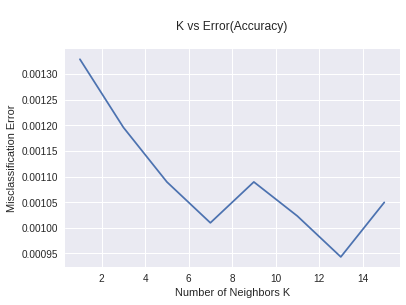

In [0]:

neighbors_li = list(neighbors) 

print(cv_scores)

####
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors_li[MSE.index(min(MSE))]
print ("\nThe optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.title('\nK vs Error(Accuracy)\n')
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()




---



###TESTE K SEGUNDO ROC AUC###

In [0]:
%%time

# subsetting just the odd ones
neighbors2 = [1,3,5,7,9,11,13,15]     #TESTE COM 8 VALORES APENAS


# empty list that will hold cv scores
cv_scores_auc = []

# perform 10-fold cross validation
for k in neighbors2:
    knn_auc = KNeighborsClassifier(n_neighbors = k)
    scores_auc = cross_val_score(knn_auc, X_test, labels_kmeans_test, cv = time_split, scoring='roc_auc')
    cv_scores_auc.append(scores_auc.mean())


CPU times: user 9min 31s, sys: 4.71 s, total: 9min 36s
Wall time: 9min 36s


[0.9921012714970612, 0.9985985603029288, 0.9997339548641028, 0.9999614712854525, 0.999964123187854, 0.9999624483745467, 0.9999707973913677, 0.9999680295788128]

The optimal number of neighbors is 13


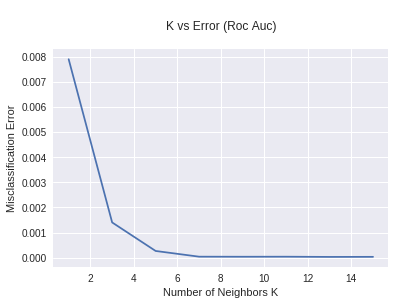

In [0]:
print(cv_scores_auc)

####
# changing to misclassification error
MSE_auc = [1 - x for x in cv_scores_auc]

# determining best k
optimal_k_auc = neighbors2[MSE_auc.index(min(MSE_auc))]
print ("\nThe optimal number of neighbors is %d" % optimal_k_auc)

# plot misclassification error vs k
plt.plot(neighbors2, MSE_auc)
plt.title('\nK vs Error (Roc Auc)\n')
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()



---



##APLICANDO O KNN COM K ESCOLHIDO##

In [0]:
#KNN OPTIMAL

knn_opt = KNeighborsClassifier(n_neighbors = optimal_k)

knn_opt.fit(X_test, labels_kmeans_test )

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=13, p=2,
           weights='uniform')

##PREVENDO OS VALORES DO CONJUNTO TREINO UTILIZANDO O KNN##

In [0]:
%%time

labels_knn_train = knn_opt.predict(X_train)

CPU times: user 9min 40s, sys: 3.54 s, total: 9min 43s
Wall time: 9min 44s


In [0]:
print(labels_knn_train)

print('nº zeros: ', np.sum(labels_knn_train == 0))
print('nº uns: ', np.sum(labels_knn_train == 1))

[0 0 0 ... 0 0 0]
nº zeros:  246724
nº uns:  6837


##MATRIZ DE CONFUSÃO##



---



In [0]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train, labels_knn_train)

print(cm)

[[244427   6837]
 [  2297      0]]


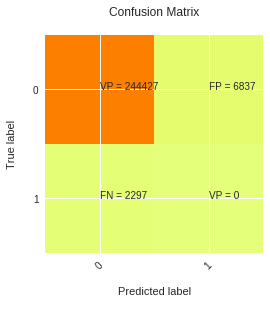

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title('Confusion Matrix\n')
plt.ylabel('True label\n')
plt.xlabel('\nPredicted label\n')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['VP','FP'], ['FN', 'VP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()



---



In [0]:
train_df['labels_originais'] = y_train
train_df['labels_knn'] = labels_knn_train

train_df

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,site7,time7,site8,time8,site9,time9,site10,time10,labels_originais,labels_knn
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0,0
242171,952,2013-01-12 08:50:22,947.0,2013-01-12 08:50:23,953.0,2013-01-12 08:50:23,946.0,2013-01-12 08:50:23,947.0,2013-01-12 08:50:24,...,953.0,2013-01-12 08:50:24,955.0,2013-01-12 08:50:24,946.0,2013-01-12 08:50:25,947.0,2013-01-12 08:50:25,0,0
57157,953,2013-01-12 08:50:25,947.0,2013-01-12 08:50:26,946.0,2013-01-12 08:50:26,953.0,2013-01-12 08:50:26,955.0,2013-01-12 08:50:26,...,953.0,2013-01-12 08:50:27,946.0,2013-01-12 08:50:27,953.0,2013-01-12 08:50:28,1033.0,2013-01-12 08:50:28,0,0
240201,946,2013-01-12 08:50:28,947.0,2013-01-12 08:50:28,954.0,2013-01-12 08:50:28,953.0,2013-01-12 08:50:29,946.0,2013-01-12 08:50:29,...,946.0,2013-01-12 08:50:30,956.0,2013-01-12 08:50:30,957.0,2013-01-12 08:50:31,956.0,2013-01-12 08:50:31,0,0
210686,946,2013-01-12 08:50:31,956.0,2013-01-12 08:50:32,946.0,2013-01-12 08:50:32,946.0,2013-01-12 08:50:33,955.0,2013-01-12 08:50:33,...,946.0,2013-01-12 08:50:34,946.0,2013-01-12 08:50:35,946.0,2013-01-12 08:50:36,948.0,2013-01-12 08:50:36,0,0




---

